In [1]:
!pip install allennlp

import os
import sys
import json
import pickle
import random
import unicodedata
from tqdm import tqdm
from typing import Iterator, List, Dict
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
import nltk
from nltk.tokenize import word_tokenize
from allennlp.data.tokenizers import Token
from allennlp.data.fields import TextField, LabelField
from allennlp.data import Instance
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.models import Model
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper
from allennlp.modules.seq2vec_encoders import PytorchSeq2VecWrapper, Seq2VecEncoder
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.data.vocabulary import Vocabulary
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.modules.token_embedders import Embedding
from allennlp.data.iterators import BucketIterator,BasicIterator
from allennlp.training.trainer import Trainer
from allennlp.predictors import SentenceTaggerPredictor

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

# Wiki

In [0]:
input_path = 'Source/wiki-pages-text/'
wiki_dict = defaultdict(dict)

for i in tqdm(range(1, 110)):
    file_name = str(i).zfill(3)
    input_file = input_path + "wiki-" + file_name + '.txt'

    with open(input_file, 'r+') as wiki_file:
        for entry in wiki_file:
            entry = entry.split(' ')
            title = unicodedata.normalize('NFD', entry[0])
            label = unicodedata.normalize('NFD', entry[1])
            text = unicodedata.normalize('NFD', " ".join(entry[2:]))
            wiki_dict[title][label] = text

In [0]:
wiki_dict['Makani_Narayana_Rao']

# Distribution

In [9]:
label_count = Counter()
evidence_count = Counter()
sentence_length_count = Counter()
with open('train_input.txt', 'rb') as t:
    train_input = pickle.load(t)
    for t in tqdm(train_input):
        label_count[t['label']] += 1
        evidence_count[len(t['evidence'])] += 1
#         for e in t['evidence']:
#             sentence_length_count[len([word for word in word_tokenize(wiki_dict[e[0]][str(e[1])])])] += 1
res = evidence_count.most_common()
sentence_res = sentence_length_count.most_common()
label_res = label_count.most_common()
res.sort()
sentence_res.sort()
label_res.sort()

100%|██████████| 145449/145449 [00:00<00:00, 851866.42it/s]


[('NOT ENOUGH INFO', 35639), ('REFUTES', 29775), ('SUPPORTS', 80035)]


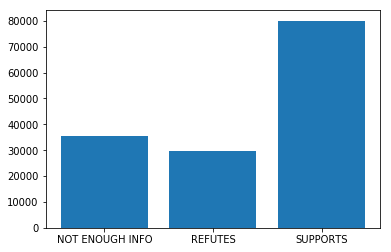

In [13]:
print(label_res)
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in label_res],[j for i,j in label_res])

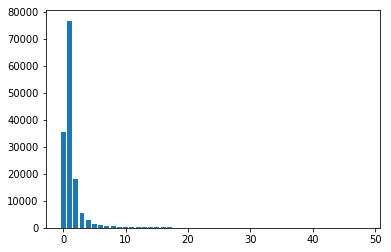

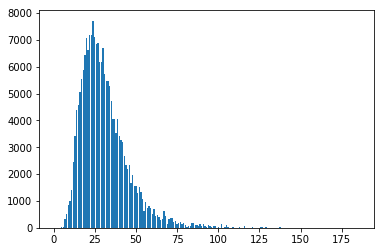

In [0]:
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in res],[j for i,j in res])
fig, axes = plt.subplots()
bar = plt.bar([i for i, j in sentence_res],[j for i,j in sentence_res])

# Related Classifier

In [0]:
class VerbDatasetReader(DatasetReader):

    def __init__(self,sentence_indexers:Dict[str,TokenIndexer] = None)-> None:
        super().__init__(lazy=False)
        self.sentence_indexers=sentence_indexers or {"sentence":SingleIdTokenIndexer()}

    def text_to_instance(self, sentence:str ,labels:str = None)->Instance:
        sent_tokenized=[]
        for word in word_tokenize(sentence):
            sent_tokenized.append(Token(word))
#         print(sent_tokenized)
        sentence_field=TextField(sent_tokenized,self.sentence_indexers)
        fields={'sentence':sentence_field,'labels':LabelField(labels)}
        return Instance(fields)

    def _read(self, file_path: str)->Iterator[Instance]:
        with open(file_path, 'rb') as f:
            train = pickle.load(f)
            pre = ""
            for value in train[:1000]:
                if value['label'] == "NOT ENOUGH INFO":
                    instance = claim + ' ' + pre
                    yield self.text_to_instance(instance, value['label'])
                else:
                    claim = value['claim']
                    for e in value['evidence']:
                        pre = ' '.join(e)
                        instance = claim + ' '  + pre
    #                     print(instance)
                        yield self.text_to_instance(instance, value['label'])

reader=VerbDatasetReader()
train_dataset=reader.read('train_input.txt')

random.shuffle(train_dataset)

validation_set = train_dataset[:50]
train_set = train_dataset[50:]



0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
214it [00:01,  1.25it/s]
428it [00:01,  1.79it/s]
646it [00:01,  2.55it/s]
855it [00:01,  3.64it/s]
1061it [00:01,  5.20it/s]
1282it [00:01,  7.41it/s]
1485it [00:01, 10.58it/s]
1690it [00:01, 15.08it/s]
1901it [00:02, 21.47it/s]
2111it [00:02, 30.54it/s]
2333it [00:02, 43.37it/s]
2551it [00:02, 61.43it/s]
2763it [00:02, 83.00it/s]
2956it [00:02, 116.42it/s]
3165it [00:03, 162.43it/s]
3370it [00:03, 224.40it/s]
3584it [00:03, 306.75it/s]
3781it [00:03, 410.01it/s]
3994it [00:03, 541.02it/s]
4198it [00:03, 693.97it/s]
4407it [00:03, 867.12it/s]
4618it [00:03, 1052.88it/s]
4836it [00:03, 1246.16it/s]
5054it [00:03, 1429.35it/s]
5269it [00:04, 1588.71it/s]
5491it [00:04, 1736.44it/s]
5714it [00:04, 1856.82it/s]
5937it [00:04, 1953.66it/s]
6156it [00:04, 2018.38it/s]
6375it [00:04, 2032.68it/s]
6591it [00:05, 955.53it/s] 
6814it [00:05, 1152.49it/s]
7034it [00:05, 1344.01it/s]
7236it [00:05, 1493.45it/s]
7450it [00:05, 1641.76it/s]
7659it [00:05,

55983it [00:31, 2064.04it/s]
56201it [00:31, 2095.76it/s]
56416it [00:31, 2111.16it/s]
56643it [00:31, 2154.41it/s]
56859it [00:31, 2115.78it/s]
57072it [00:31, 2077.78it/s]
57285it [00:31, 2090.50it/s]
57495it [00:31, 2052.25it/s]
57711it [00:32, 2082.13it/s]
57920it [00:32, 2047.43it/s]
58126it [00:32, 2006.42it/s]
58328it [00:32, 1993.94it/s]
58529it [00:32, 1997.78it/s]
58745it [00:32, 2043.69it/s]
58950it [00:32, 2041.01it/s]
59159it [00:32, 2051.73it/s]
59378it [00:32, 2089.62it/s]
59588it [00:32, 2070.76it/s]
59797it [00:33, 2076.46it/s]
60009it [00:33, 2085.38it/s]
60222it [00:33, 2097.86it/s]
60432it [00:33, 2086.15it/s]
60641it [00:33, 2084.30it/s]
60850it [00:34, 514.14it/s] 
61066it [00:34, 666.36it/s]
61294it [00:34, 845.70it/s]
61517it [00:34, 1039.15it/s]
61739it [00:34, 1235.76it/s]
61945it [00:35, 1392.83it/s]
62164it [00:35, 1562.70it/s]
62375it [00:35, 1693.86it/s]
62584it [00:35, 1778.88it/s]
62796it [00:35, 1867.96it/s]
63004it [00:35, 1925.14it/s]
63220it [00:35, 

110460it [01:00, 2071.51it/s]
110668it [01:00, 2053.85it/s]
110880it [01:00, 2072.36it/s]
111088it [01:00, 2039.77it/s]
111296it [01:00, 2051.55it/s]
111502it [01:01, 2050.97it/s]
111709it [01:01, 2056.49it/s]
111915it [01:01, 2033.66it/s]
112124it [01:01, 2048.04it/s]
112330it [01:01, 2048.52it/s]
112537it [01:01, 2054.86it/s]
112743it [01:01, 2026.55it/s]
112946it [01:01, 1991.33it/s]
113160it [01:01, 2031.60it/s]
113364it [01:02, 2014.22it/s]
113566it [01:02, 2006.00it/s]
113776it [01:02, 2029.58it/s]
113980it [01:02, 2026.52it/s]
114184it [01:02, 2028.87it/s]
114387it [01:02, 2001.45it/s]
114599it [01:02, 2035.32it/s]
114819it [01:02, 2081.54it/s]
115032it [01:02, 2095.02it/s]
115254it [01:02, 2129.12it/s]
115468it [01:03, 2121.95it/s]
115681it [01:03, 2088.94it/s]
115891it [01:03, 2084.68it/s]
116100it [01:03, 2080.09it/s]
116311it [01:03, 2087.98it/s]
116533it [01:03, 2125.13it/s]
116758it [01:03, 2157.96it/s]
116976it [01:03, 2163.74it/s]
117193it [01:03, 2121.34it/s]
117406it [

In [0]:
len(train_set)

145399

In [0]:
vocab=Vocabulary.from_instances(train_dataset)

EMBEDDING_DIM = 300
HIDDEN_DIM = 6

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'), embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"sentence": token_embedding})


100%|██████████| 145449/145449 [00:06<00:00, 22938.63it/s]

In [0]:
class Lstm(Model):
    def __init__(self,
                 word_embeddings:TextFieldEmbedder,
                 encoder:Seq2VecEncoder,
                 vocab:Vocabulary)->None:
        super().__init__(vocab)
        self.word_embeddings=word_embeddings
        self.encoder=encoder
        self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),out_features=vocab.get_vocab_size('labels'))
        self.accuracy = CategoricalAccuracy()

    def forward(self,
                sentence:Dict[str,torch.Tensor],
                labels:torch.Tensor=None)->Dict[str,torch.Tensor]:
        mask=get_text_field_mask(sentence)
        embeddings = self.word_embeddings(sentence)
        encoder_out = self.encoder(embeddings, mask)
        tag_logits=self.hidden2tag(encoder_out)
        output = {"tag_logits": tag_logits}
        if labels is not None:
            self.accuracy(tag_logits, labels)
            loss=torch.nn.CrossEntropyLoss()
            output['loss'] = loss(tag_logits,labels)
        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}

lstm = PytorchSeq2VecWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = Lstm(word_embeddings, lstm, vocab)

optimizer = optim.SGD(model.parameters(), lr=0.1)

iterator=BasicIterator()

iterator.index_with(vocab)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_set,
                  validation_dataset=validation_set,
                  patience=10,
                  num_epochs=3)

trainer.train()


  0%|          | 0/4544 [00:00<?, ?it/s]
accuracy: 0.3125, loss: 1.1072 ||:   0%|          | 1/4544 [00:01<1:21:57,  1.08s/it]
accuracy: 0.2812, loss: 1.1177 ||:   0%|          | 2/4544 [00:01<1:02:06,  1.22it/s]
accuracy: 0.2917, loss: 1.1030 ||:   0%|          | 3/4544 [00:01<47:01,  1.61it/s]  
accuracy: 0.2969, loss: 1.0931 ||:   0%|          | 4/4544 [00:01<39:09,  1.93it/s]
accuracy: 0.3063, loss: 1.0929 ||:   0%|          | 5/4544 [00:01<33:07,  2.28it/s]
accuracy: 0.2969, loss: 1.1013 ||:   0%|          | 6/4544 [00:02<26:37,  2.84it/s]
accuracy: 0.2857, loss: 1.0990 ||:   0%|          | 7/4544 [00:02<22:10,  3.41it/s]
accuracy: 0.2891, loss: 1.0916 ||:   0%|          | 8/4544 [00:02<18:57,  3.99it/s]
accuracy: 0.2812, loss: 1.0901 ||:   0%|          | 9/4544 [00:02<16:43,  4.52it/s]
accuracy: 0.2750, loss: 1.0924 ||:   0%|          | 10/4544 [00:02<15:16,  4.95it/s]
accuracy: 0.2955, loss: 1.0888 ||:   0%|          | 11/4544 [00:02<14:07,  5.35it/s]
accuracy: 0.3125, loss: 1.

accuracy: 0.5017, loss: 1.0315 ||:   2%|▏         | 93/4544 [00:22<17:48,  4.17it/s]
accuracy: 0.5013, loss: 1.0317 ||:   2%|▏         | 94/4544 [00:22<16:26,  4.51it/s]
accuracy: 0.5033, loss: 1.0302 ||:   2%|▏         | 95/4544 [00:22<18:03,  4.11it/s]
accuracy: 0.5042, loss: 1.0297 ||:   2%|▏         | 96/4544 [00:23<19:57,  3.71it/s]
accuracy: 0.5045, loss: 1.0294 ||:   2%|▏         | 97/4544 [00:23<18:46,  3.95it/s]
accuracy: 0.5048, loss: 1.0295 ||:   2%|▏         | 98/4544 [00:23<19:44,  3.75it/s]
accuracy: 0.5073, loss: 1.0274 ||:   2%|▏         | 99/4544 [00:24<22:26,  3.30it/s]
accuracy: 0.5066, loss: 1.0281 ||:   2%|▏         | 100/4544 [00:24<21:15,  3.48it/s]
accuracy: 0.5068, loss: 1.0281 ||:   2%|▏         | 101/4544 [00:24<19:04,  3.88it/s]
accuracy: 0.5058, loss: 1.0291 ||:   2%|▏         | 102/4544 [00:24<17:04,  4.33it/s]
accuracy: 0.5061, loss: 1.0289 ||:   2%|▏         | 103/4544 [00:24<15:11,  4.87it/s]
accuracy: 0.5066, loss: 1.0284 ||:   2%|▏         | 104/4544 

accuracy: 0.5287, loss: 1.0131 ||:   4%|▍         | 185/4544 [00:42<12:40,  5.73it/s]
accuracy: 0.5297, loss: 1.0122 ||:   4%|▍         | 186/4544 [00:42<16:10,  4.49it/s]
accuracy: 0.5307, loss: 1.0112 ||:   4%|▍         | 187/4544 [00:42<15:27,  4.70it/s]
accuracy: 0.5316, loss: 1.0105 ||:   4%|▍         | 188/4544 [00:42<15:06,  4.81it/s]
accuracy: 0.5321, loss: 1.0100 ||:   4%|▍         | 189/4544 [00:42<15:26,  4.70it/s]
accuracy: 0.5317, loss: 1.0104 ||:   4%|▍         | 190/4544 [00:43<15:38,  4.64it/s]
accuracy: 0.5322, loss: 1.0100 ||:   4%|▍         | 191/4544 [00:43<16:57,  4.28it/s]
accuracy: 0.5321, loss: 1.0102 ||:   4%|▍         | 192/4544 [00:43<16:12,  4.47it/s]
accuracy: 0.5314, loss: 1.0109 ||:   4%|▍         | 193/4544 [00:44<19:55,  3.64it/s]
accuracy: 0.5312, loss: 1.0110 ||:   4%|▍         | 194/4544 [00:44<20:08,  3.60it/s]
accuracy: 0.5312, loss: 1.0111 ||:   4%|▍         | 195/4544 [00:44<18:58,  3.82it/s]
accuracy: 0.5311, loss: 1.0112 ||:   4%|▍         | 19

accuracy: 0.5351, loss: 1.0090 ||:   6%|▌         | 277/4544 [01:02<12:55,  5.51it/s]
accuracy: 0.5350, loss: 1.0092 ||:   6%|▌         | 278/4544 [01:02<12:29,  5.69it/s]
accuracy: 0.5352, loss: 1.0090 ||:   6%|▌         | 279/4544 [01:02<11:37,  6.11it/s]
accuracy: 0.5355, loss: 1.0087 ||:   6%|▌         | 280/4544 [01:03<11:36,  6.12it/s]
accuracy: 0.5354, loss: 1.0089 ||:   6%|▌         | 281/4544 [01:03<12:17,  5.78it/s]
accuracy: 0.5352, loss: 1.0090 ||:   6%|▌         | 282/4544 [01:03<13:48,  5.15it/s]
accuracy: 0.5354, loss: 1.0088 ||:   6%|▌         | 283/4544 [01:03<13:09,  5.40it/s]
accuracy: 0.5351, loss: 1.0091 ||:   6%|▋         | 284/4544 [01:03<15:39,  4.53it/s]
accuracy: 0.5349, loss: 1.0094 ||:   6%|▋         | 285/4544 [01:04<14:46,  4.80it/s]
accuracy: 0.5350, loss: 1.0092 ||:   6%|▋         | 286/4544 [01:04<14:24,  4.93it/s]
accuracy: 0.5351, loss: 1.0092 ||:   6%|▋         | 287/4544 [01:04<14:47,  4.80it/s]
accuracy: 0.5345, loss: 1.0096 ||:   6%|▋         | 28

KeyboardInterrupt: 

# DatasetReader

In [14]:
class VerbDatasetReader(DatasetReader):

    def __init__(self,sentence_indexers:Dict[str,TokenIndexer] = None)-> None:
        super().__init__(lazy=False)
        self.sentence_indexers=sentence_indexers or {"sentence":SingleIdTokenIndexer()}

    def text_to_instance(self, sentence:str ,labels:str = None)->Instance:
        sent_tokenized=[]
        for word in word_tokenize(sentence):
            sent_tokenized.append(Token(word))
#         print(sent_tokenized)
        sentence_field=TextField(sent_tokenized,self.sentence_indexers)
        fields={'sentence':sentence_field,'labels':LabelField(labels)}
        return Instance(fields)

    def _read(self, file_path: str)->Iterator[Instance]:
        with open(file_path, 'rb') as f:
            train = pickle.load(f)
            pre = ""
            for value in train:
                claim = value['claim']
                if value['label'] == "NOT ENOUGH INFO":
                    continue
                    instance = claim + ' ' + pre
                    yield self.text_to_instance(instance, value['label'])
                else:
                    instance = claim
                    i = 0
                    for e in value['evidence']:
                        pre = ' '.join(e)
                        instance += ' '  + pre
                        i += 1
                        if i >= 3:
                            break
                    yield self.text_to_instance(instance, value['label'])

reader=VerbDatasetReader()
train_dataset=reader.read('train_input.txt')

random.shuffle(train_dataset)

validation_set = train_dataset[:3000]
train_set = train_dataset[3000:]

109810it [01:04, 1711.59it/s]


# Embedding

In [15]:
vocab=Vocabulary.from_instances(train_dataset)

EMBEDDING_DIM = 300
HIDDEN_DIM = 6

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'), embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"sentence": token_embedding})

100%|██████████| 109810/109810 [00:05<00:00, 19827.96it/s]


# Lstm

In [17]:
class Lstm(Model):
    def __init__(self,
                 word_embeddings:TextFieldEmbedder,
                 encoder:Seq2VecEncoder,
                 vocab:Vocabulary)->None:
        super().__init__(vocab)
        self.word_embeddings=word_embeddings
        self.encoder=encoder
        self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),out_features=vocab.get_vocab_size('labels'))
        self.accuracy = CategoricalAccuracy()

    def forward(self,
                sentence:Dict[str,torch.Tensor],
                labels:torch.Tensor==None)->Dict[str,torch.Tensor]:
        mask=get_text_field_mask(sentence)
        embeddings = self.word_embeddings(sentence)
        encoder_out = self.encoder(embeddings, mask)
        tag_logits=self.hidden2tag(encoder_out)
        output = {"tag_logits": tag_logits}
        if labels is not None:
            self.accuracy(tag_logits, labels)
            loss=torch.nn.CrossEntropyLoss()
            output['loss'] = loss(tag_logits,labels)
        return output

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}

lstm = PytorchSeq2VecWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True))

model = Lstm(word_embeddings, lstm, vocab)

if torch.cuda.is_available():
    cuda_device = 0
    model = model.cuda(cuda_device)
else:
    cuda_device = -1

optimizer = optim.SGD(model.parameters(), lr=0.1)

iterator=BasicIterator()

iterator.index_with(vocab)

trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_set,
                  validation_dataset=validation_set,
                  patience=10,
                  num_epochs=5,
                  cuda_device=cuda_device)

trainer.train()


  0%|          | 0/3338 [00:00<?, ?it/s]
accuracy: 0.7188, loss: 0.6550 ||:   0%|          | 1/3338 [00:00<14:07,  3.94it/s]
accuracy: 0.7448, loss: 0.6214 ||:   0%|          | 6/3338 [00:00<10:15,  5.42it/s]
accuracy: 0.7585, loss: 0.5961 ||:   0%|          | 11/3338 [00:00<07:31,  7.37it/s]
accuracy: 0.7344, loss: 0.6055 ||:   0%|          | 16/3338 [00:00<05:35,  9.90it/s]
accuracy: 0.7351, loss: 0.5999 ||:   1%|          | 21/3338 [00:00<04:14, 13.02it/s]
accuracy: 0.7407, loss: 0.5907 ||:   1%|          | 27/3338 [00:00<03:16, 16.84it/s]
accuracy: 0.7396, loss: 0.5888 ||:   1%|          | 33/3338 [00:00<02:37, 21.01it/s]
accuracy: 0.7396, loss: 0.5866 ||:   1%|          | 39/3338 [00:01<02:08, 25.63it/s]
accuracy: 0.7438, loss: 0.5806 ||:   1%|▏         | 45/3338 [00:01<01:47, 30.51it/s]
accuracy: 0.7412, loss: 0.5823 ||:   1%|▏         | 50/3338 [00:01<01:35, 34.39it/s]
accuracy: 0.7388, loss: 0.5836 ||:   2%|▏         | 56/3338 [00:01<01:25, 38.41it/s]
accuracy: 0.7374, loss: 0

{'best_epoch': 4,
 'best_validation_accuracy': 0.731,
 'best_validation_loss': 0.5804825181022604,
 'epoch': 4,
 'peak_cpu_memory_MB': 5003.684,
 'peak_gpu_0_memory_MB': 1033,
 'training_accuracy': 0.728789439191087,
 'training_cpu_memory_MB': 5003.684,
 'training_duration': '00:04:25',
 'training_epochs': 4,
 'training_gpu_0_memory_MB': 1033,
 'training_loss': 0.5804883599227741,
 'training_start_epoch': 0,
 'validation_accuracy': 0.731,
 'validation_loss': 0.5804825181022604}

In [0]:
predictor = SentenceTaggerPredictor(model, dataset_reader=reader)
for i in range(1600, 2000):
    tag_logits = predictor.predict_instance(train_dataset[i])
    tag_ids = np.argmax(tag_logits, axis=-1)
    print(tag_ids)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [0]:
with open("test.th", 'wb') as f:
    torch.save(model.state_dict(), f)
    
vocab.save_to_files("vocabulary")